<a href="https://colab.research.google.com/github/shaunak09vb/Toxic-Comment-Classifier-using-Deep-Learning/blob/main/NLP_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Libraries

In [1]:
import numpy as np, pandas as pd
import re
import spacy
from spacy.lang.en import English
from spacy.lang.en.stop_words import STOP_WORDS
from nltk.tokenize import word_tokenize
import nltk
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
import string
from string import ascii_lowercase

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\joani\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [9]:
from tqdm import tqdm_notebook
import itertools
import io

import matplotlib.pyplot as plt
%matplotlib inline

from functools import reduce
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D
from keras.layers import BatchNormalization
from keras import initializers, regularizers, constraints, optimizers, layers
#import talos

# Importing Data

In [3]:
train=pd.read_csv("data/train.csv")    

In [4]:
train.shape

(159571, 8)

In [5]:
test=pd.read_csv("data/test.csv")

In [6]:
test.head()
test.shape

(153164, 2)

# Data Exploration

Checking for missing values

In [7]:
train.isnull().any()

id               False
comment_text     False
toxic            False
severe_toxic     False
obscene          False
threat           False
insult           False
identity_hate    False
dtype: bool

In [8]:
test.isnull().any()

id              False
comment_text    False
dtype: bool

In [9]:
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
y = train[labels].values

#Data Pre-processing

## Text Normalization

* Removing Characters in between Text
* Removing Repeated Characters
* Converting data to lower-case
* Removing Numbers from the data
* Remove Punctuation
* Remove Whitespaces
* Removing spaces in between words
* Removing "\n"
* Remove Non-english characters

In [10]:
RE_PATTERNS = {
    ' american ':
        [
            'amerikan'
        ],

    ' adolf ':
        [
            'adolf'
        ],


    ' hitler ':
        [
            'hitler'
        ],

    ' fuck':
        [
            '(f)(u|[^a-z0-9 ])(c|[^a-z0-9 ])(k|[^a-z0-9 ])([^ ])*',
            '(f)([^a-z]*)(u)([^a-z]*)(c)([^a-z]*)(k)',
            ' f[!@#\$%\^\&\*]*u[!@#\$%\^&\*]*k', 'f u u c',
            '(f)(c|[^a-z ])(u|[^a-z ])(k)', r'f\*',
            'feck ', ' fux ', 'f\*\*', 'f**k','fu*k',
            'f\-ing', 'f\.u\.', 'f###', ' fu ', 'f@ck', 'f u c k', 'f uck', 'f ck'
        ],

    ' ass ':
        [
            '[^a-z]ass ', '[^a-z]azz ', 'arrse', ' arse ', '@\$\$',
            '[^a-z]anus', ' a\*s\*s', '[^a-z]ass[^a-z ]',
            'a[@#\$%\^&\*][@#\$%\^&\*]', '[^a-z]anal ', 'a s s','a55', '@$$'
        ],

    ' ass hole ':
        [
            ' a[s|z]*wipe', 'a[s|z]*[w]*h[o|0]+[l]*e', '@\$\$hole', 'a**hole'
        ],

    ' bitch ':
        [
            'b[w]*i[t]*ch', 'b!tch',
            'bi\+ch', 'b!\+ch', '(b)([^a-z]*)(i)([^a-z]*)(t)([^a-z]*)(c)([^a-z]*)(h)',
            'biatch', 'bi\*\*h', 'bytch', 'b i t c h', 'b!tch', 'bi+ch', 'l3itch'
        ],

    ' bastard ':
        [
            'ba[s|z]+t[e|a]+rd'
        ],

    ' trans gender':
        [
            'transgender'
        ],

    ' gay ':
        [
            'gay'
        ],

    ' cock ':
        [
            '[^a-z]cock', 'c0ck', '[^a-z]cok ', 'c0k', '[^a-z]cok[^aeiou]', ' cawk',
            '(c)([^a-z ])(o)([^a-z ]*)(c)([^a-z ]*)(k)', 'c o c k'
        ],

    ' dick ':
        [
            ' dick[^aeiou]', 'deek', 'd i c k', 'dik'
        ],

    ' suck ':
        [
            'sucker', '(s)([^a-z ]*)(u)([^a-z ]*)(c)([^a-z ]*)(k)', 'sucks', '5uck', 's u c k'
        ],

    ' cunt ':
        [
            'cunt', 'c u n t'
        ],

    ' bull shit ':
        [
            'bullsh\*t', 'bull\$hit'
        ],

    ' homo sex ual':
        [
            'homosexual'
        ],

    ' jerk ':
        [
            'jerk'
        ],

    ' idiot ':
        [
            'i[d]+io[t]+', '(i)([^a-z ]*)(d)([^a-z ]*)(i)([^a-z ]*)(o)([^a-z ]*)(t)', 'idiots'
                                                                                      'i d i o t'
        ],

    ' dumb ':
        [
            '(d)([^a-z ]*)(u)([^a-z ]*)(m)([^a-z ]*)(b)'
        ],

    ' shit ':
        [
            'shitty', '(s)([^a-z ]*)(h)([^a-z ]*)(i)([^a-z ]*)(t)', 'shite', '\$hit', 's h i t', '$h1t'
        ],

    ' shit hole ':
        [
            'shythole'
        ],

    ' retard ':
        [
            'returd', 'retad', 'retard', 'wiktard', 'wikitud'
        ],

    ' rape ':
        [
            ' raped'
        ],

    ' dumb ass':
        [
            'dumbass', 'dubass'
        ],

    ' ass head':
        [
            'butthead'
        ],

    ' sex ':
        [
            'sexy', 's3x', 'sexuality'
        ],


    ' nigger ':
        [
            'nigger', 'ni[g]+a', ' nigr ', 'negrito', 'niguh', 'n3gr', 'n i g g e r'
        ],

    ' shut the fuck up':
        [
            'stfu', 'st*u'
        ],

    ' pussy ':
        [
            'pussy[^c]', 'pusy', 'pussi[^l]', 'pusses', 'p*ssy'
        ],

    ' faggot ':
        [
            'faggot', ' fa[g]+[s]*[^a-z ]', 'fagot', 'f a g g o t', 'faggit',
            '(f)([^a-z ]*)(a)([^a-z ]*)([g]+)([^a-z ]*)(o)([^a-z ]*)(t)', 'fau[g]+ot', 'fae[g]+ot',
        ],

    ' mother fucker':
        [
            ' motha ', ' motha f', ' mother f', 'motherucker',
        ],

    ' whore ':
        [
            'wh\*\*\*', 'w h o r e'
        ],
    ' fucking ':
        [
            'f*$%-ing'
        ],
}


In [11]:
def clean_text(text,remove_repeat_text=True, remove_patterns_text=True, is_lower=True):

    if is_lower:
        text=text.lower()

    if remove_patterns_text:
        for target, patterns in RE_PATTERNS.items():
            for pat in patterns:
                text=str(text).replace(pat, target)

    if remove_repeat_text:
        text = re.sub(r'(.)\1{2,}', r'\1', text) 

    text = str(text).replace("\n", " ")
    text = re.sub(r'[^\w\s]',' ',text)
    text = re.sub('[0-9]',"",text)
    text = re.sub(" +", " ", text)
    text = re.sub("([^\x00-\x7F])+"," ",text)
    return text 

Cleaning Training Data

In [12]:
train['comment_text']=train['comment_text'].apply(lambda x: clean_text(x))
train['comment_text'][1]

'd aww he matches this background colour i m seemingly stuck with thanks talk january utc '

Cleaning Test Data

In [13]:
test['comment_text']=test['comment_text'].apply(lambda x: clean_text(x))
test['comment_text'][1048]

'this is a university ip address just fyi '

## Lemmatization

In [14]:
comments_train=train['comment_text']
comments_test=test['comment_text']

In [15]:
comments_test

0         yo bitch ja rule is more succesful then you ll...
1                  from rfc the title is fine as it is imo 
2                           sources zawe ashton on lapland 
3          if you have a look back at the source the inf...
4                 i don t anonymously edit articles at all 
                                ...                        
153159     i totally agree this stuff is nothing but too...
153160     throw from out field to home plate does it ge...
153161     okinotorishima categories i see your changes ...
153162     one of the founding nations of the eu germany...
153163     stop already your bullshit is not welcome her...
Name: comment_text, Length: 153164, dtype: object

In [16]:
comments_train=list(comments_train)
comments_test=list(comments_test)

In [17]:
wordnet_lemmatizer = WordNetLemmatizer()

In [18]:
def lemma(text, lemmatization=True):
    output=""
    if lemmatization:
        text=text.split(" ")
    for word in text:
        word1 = wordnet_lemmatizer.lemmatize(word, pos = "n")
        word2 = wordnet_lemmatizer.lemmatize(word1, pos = "v")
        word3 = wordnet_lemmatizer.lemmatize(word2, pos = "a")
        word4 = wordnet_lemmatizer.lemmatize(word3, pos = "r")
        output= output + " " + word4
    else:
        output=text

    return str((" ".join(output)).strip()) 

Lemmatizing Training Data

In [19]:
lemmatized_train_data = [] 

for line in tqdm_notebook(comments_train, total=159571): 
    lemmatized_train_data.append(lemma(line))

C:\Users\joani\AppData\Local\Temp\ipykernel_11484\1680104881.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for line in tqdm_notebook(comments_train, total=159571):


  0%|          | 0/159571 [00:00<?, ?it/s]

In [20]:
lemmatized_train_data[152458]

'i agree with you about graemel s intentions he is a revert nazi and wikipedia has a way of protecting against this report him to the wp rr three revert rule notice board posted by report the revert nazi graemel has shown himself herself to be a revert nazi this is unacceptable on a site that is made by it s users and not it s admins if you feel you have been unjustly reverted more than times over a hour period please report him her to the three revert noticeboard wp rr it is time to take back what is ours'

Lemmatizing Test Data

In [21]:
lemmatized_test_data = [] 

for line in tqdm_notebook(comments_test, total=len(comments_test)): 
    lemmatized_test_data.append(lemma(line))

C:\Users\joani\AppData\Local\Temp\ipykernel_11484\3519428647.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for line in tqdm_notebook(comments_test, total=len(comments_test)):


  0%|          | 0/153164 [00:00<?, ?it/s]

In [22]:
lemmatized_test_data[10]

'i think its crap that the link to roggenbier is to this article somebody that knows how to do things should change it'

## Stopwords Removal

In [23]:
stopword_list=STOP_WORDS

Adding Single and Dual to STOP_WORDS

In [24]:
def iter_all_strings():
    for size in itertools.count(1):
        for s in itertools.product(ascii_lowercase, repeat=size):
            yield "".join(s)

dual_alpha_list=[]
for s in iter_all_strings():
    dual_alpha_list.append(s)
    if s == 'zz':
        break

In [25]:
dual_alpha_list.remove('i')
dual_alpha_list.remove('a')
dual_alpha_list.remove('am')
dual_alpha_list.remove('an')
dual_alpha_list.remove('as')
dual_alpha_list.remove('at')
dual_alpha_list.remove('be')
dual_alpha_list.remove('by')
dual_alpha_list.remove('do')
dual_alpha_list.remove('go')
dual_alpha_list.remove('he')
dual_alpha_list.remove('hi')
dual_alpha_list.remove('if')
dual_alpha_list.remove('is')
dual_alpha_list.remove('in')
dual_alpha_list.remove('me')
dual_alpha_list.remove('my')
dual_alpha_list.remove('no')
dual_alpha_list.remove('of')
dual_alpha_list.remove('on')
dual_alpha_list.remove('or')
dual_alpha_list.remove('ok')
dual_alpha_list.remove('so')
dual_alpha_list.remove('to')
dual_alpha_list.remove('up')
dual_alpha_list.remove('us')
dual_alpha_list.remove('we')

In [26]:
for letter in dual_alpha_list:
    stopword_list.add(letter)
print("Done!!")

Done!!


Checking for other words that we may need in STOP_WORDS

In [27]:
def search_stopwords(data, search_stop=True):
    output=""
    if search_stop:
        data=data.split(" ")
    for word in data:
        if not word in stopword_list:
            output=output+" "+word 
    else:
        output=data

    return str(" ".join(output).strip())  

In [28]:
potential_stopwords = [] 

for line in tqdm_notebook(lemmatized_train_data, total=159571): 
    potential_stopwords.append(search_stopwords(line))

C:\Users\joani\AppData\Local\Temp\ipykernel_11484\4143303515.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for line in tqdm_notebook(lemmatized_train_data, total=159571):


  0%|          | 0/159571 [00:00<?, ?it/s]

In [29]:
len(potential_stopwords)

159571

Combining all the sentences in the list into a single string

In [30]:
def string_combine_a(stopword):
    final_a=""
    for item in range(39893):
        final_a=final_a+" "+stopword[item]
    return final_a

def string_combine_b(stopword):
    final_b=""
    for item in range(39893,79785):
        final_b=final_b+" "+stopword[item]
    return final_b

def string_combine_c(stopword):
    final_c=""
    for item in range(79785,119678):
        final_c=final_c+" "+stopword[item]
    return final_c

def string_combine_d(stopword):
    final_d=""
    for item in range(119678,159571):
        final_d=final_d+" "+stopword[item]
    return final_d

In [31]:
total_string_potential_a=string_combine_a(potential_stopwords)
total_string_potential_b=string_combine_b(potential_stopwords)
total_string_potential_c=string_combine_c(potential_stopwords)
total_string_potential_d=string_combine_d(potential_stopwords)

Counting the number of words in each of the 4 strings

In [32]:
def word_count(str):
    counts = dict()
    words = str.split()

    for word in words:
        if word in counts:
            counts[word] += 1
        else:
            counts[word] = 1

    return counts

In [33]:
total_string_potential_a_dict=word_count(total_string_potential_a)
total_string_potential_b_dict=word_count(total_string_potential_b)
total_string_potential_c_dict=word_count(total_string_potential_c)
total_string_potential_d_dict=word_count(total_string_potential_d)

Converting Dictionaries to Dataframe

In [34]:
total_string_potential_a_df = pd.DataFrame(list(total_string_potential_a_dict.items()),columns = ['Word','Count'])
total_string_potential_b_df = pd.DataFrame(list(total_string_potential_b_dict.items()),columns = ['Word','Count'])
total_string_potential_c_df = pd.DataFrame(list(total_string_potential_c_dict.items()),columns = ['Word','Count'])
total_string_potential_d_df = pd.DataFrame(list(total_string_potential_d_dict.items()),columns = ['Word','Count'])

Getting Dataframe output in descending order

In [35]:
top50_potential_stopwords_a=total_string_potential_a_df.sort_values(by=['Count'],ascending=False).head(50)
top50_potential_stopwords_b=total_string_potential_b_df.sort_values(by=['Count'],ascending=False).head(50)
top50_potential_stopwords_c=total_string_potential_c_df.sort_values(by=['Count'],ascending=False).head(50)
top50_potential_stopwords_d=total_string_potential_d_df.sort_values(by=['Count'],ascending=False).head(50)

Looking for common terms in all top 50 dataframes

In [36]:
common_potential_stopwords=list(reduce(set.intersection,map(set,[top50_potential_stopwords_a.Word,top50_potential_stopwords_b.Word,top50_potential_stopwords_c.Word,top50_potential_stopwords_d.Word])))

In [37]:
print(common_potential_stopwords)

['i', 'about', 'has', 'with', 'will', 'so', 'what', 'me', 'you', 'or', 'the', 'from', 'an', 'for', 'it', 'was', 'this', 'talk', 'to', 'your', 'of', 'on', 's', 'my', 'as', 'please', 'at', 'a', 'be', 'are', 'and', 'in', 'have', 'not', 't', 'but', 'can', 'all', 'by', 'page', 'if', 'there', 'is', 'article', 'do', 'that', 'wikipedia']


Retaining certain words and removing others from the above list

In [38]:
potential_stopwords=['editor', 'reference', 'thank', 'work','find', 'good', 'know', 'like', 'look', 'thing', 'want', 'time', 'list', 'section','wikipedia', 'doe', 'add','new', 'try', 'think', 'write','use', 'user', 'way', 'page']

Adding above retrived words into the stopwords list

In [39]:
for word in potential_stopwords:
    stopword_list.add(word)
print("Done!!")

Done!!


Removing Stopwords from Training Data

In [40]:
def remove_stopwords(text, remove_stop=True):
    output = ""
    if remove_stop:
        text=text.split(" ")
    for word in text:
        if word not in stopword_list:
            output=output + " " + word
    else :
        output=text

    return str(" ".join(output).strip())      

In [41]:
processed_train_data = [] 
for line in tqdm_notebook(lemmatized_train_data, total=159571): 
    processed_train_data.append(remove_stopwords(line))

C:\Users\joani\AppData\Local\Temp\ipykernel_11484\108307155.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for line in tqdm_notebook(lemmatized_train_data, total=159571):


  0%|          | 0/159571 [00:00<?, ?it/s]

In [42]:
processed_train_data[152458]

'i agree with you about graemel s intentions he is a revert nazi and wikipedia has a way of protecting against this report him to the wp rr three revert rule notice board posted by report the revert nazi graemel has shown himself herself to be a revert nazi this is unacceptable on a site that is made by it s users and not it s admins if you feel you have been unjustly reverted more than times over a hour period please report him her to the three revert noticeboard wp rr it is time to take back what is ours'

Removing Stopwords from Test Data

In [43]:
processed_test_data = [] 
for line in tqdm_notebook(lemmatized_test_data, total=63978): 
    processed_test_data.append(remove_stopwords(line))

C:\Users\joani\AppData\Local\Temp\ipykernel_11484\469163791.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for line in tqdm_notebook(lemmatized_test_data, total=63978):


  0%|          | 0/63978 [00:00<?, ?it/s]

# Model Building

In [16]:
max_features=100000      
maxpadlen = 200          
val_split = 0.2      
embedding_dim_fasttext = 300

Tokenization

In [45]:
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(processed_train_data))
list_tokenized_train = tokenizer.texts_to_sequences(processed_train_data)
list_tokenized_test = tokenizer.texts_to_sequences(processed_test_data)

In [46]:
word_index=tokenizer.word_index
print("Words in Vocabulary: ",len(word_index))

Words in Vocabulary:  167937


Padding

In [47]:
X_t=pad_sequences(list_tokenized_train, maxlen=maxpadlen, padding = 'post')
X_te=pad_sequences(list_tokenized_test, maxlen=maxpadlen, padding = 'post')

In [48]:
print('Tokenized sentences: \n', X_t[10])
len(X_t[10])
print('Tokenized sentences: \n', X_te[10])
#print('One hot label: \n', y[10])

Tokenized sentences: 
 [  24    1  248 1969    8  269   33    1  375   18 2535   84   93  248
   59   67   16 3103   17  102   17  298    1  122   47  152    7  756
  248 3020  247   24    1  480  194   22   19   52  235   24    6  303
  606    1  488 2946   27  784   84    1  247   37   16  136    2  914
   10  179    1 2073   24    6  220    1  364 1196    1  392   36   29
  267   82   82    7  247  111   17   27   52    4    1   63  673  415
   36   29  115  248  673  267   82   66   29  115  248  673   12    1
  498  167    4  248  673    9    6   37   82   24    6   19  662   63
 1347  387 1293    9    6   19 1898   93  122    5  828   89  166    6
   37  142    7  167    4 1347    6   19  662   34  414   13  168 1168
    5 4189  340   86   16  140   52  672  150   49   19   58  828   17
  905   15  392   12  257  109   24    1  115    8 1489  179    7  278
  192 1046  493   29  267   82   84    1  115   46   16  140  747  150
   24    6   19   57  238   47  212   89   36    1  36

In [49]:
indices = np.arange(X_t.shape[0])
np.random.shuffle(indices)

In [50]:
X_t = X_t[indices]
labels = y[indices]

### Splitting data into Training and Validation Set

In [51]:
num_validation_samples = int(val_split*X_t.shape[0])
x_train = X_t[: -num_validation_samples]
y_train = labels[: -num_validation_samples]
x_val = X_t[-num_validation_samples: ]
y_val = labels[-num_validation_samples: ]
num_validation_samples
y_train.shape

(127657, 6)

In [52]:
print('Number of entries in each category:')
print('training: ', y_train.sum(axis=0))
print('validation: ', y_val.sum(axis=0))

Number of entries in each category:
training:  [12190  1298  6737   376  6294  1131]
validation:  [3104  297 1712  102 1583  274]


### Importing Fast Text

In [53]:
embeddings_index_fasttext = {}
f = open("wiki-news-300d-1M.vec", encoding='utf8')
for line in f:
    values = line.split()
    word = values[0]
    embeddings_index_fasttext[word] = np.asarray(values[1:], dtype='float32')
f.close()

In [54]:
embedding_matrix_fasttext = np.random.random((len(word_index) + 1, embedding_dim_fasttext))
for word, i in word_index.items():
    embedding_vector = embeddings_index_fasttext.get(word)
    if embedding_vector is not None:
        embedding_matrix_fasttext[i] = embedding_vector
print(" Completed!")

 Completed!


In [55]:
embedding_matrix_fasttext.shape

(167938, 300)

### Creating Model

#### Talos Grid Search  for LSTM Model

In [56]:
def toxic_classifier(x_train,y_train,x_val,y_val,params):

    inp=Input(shape=(maxpadlen, ),dtype='int32')

    embedding_layer = Embedding(len(word_index) + 1,
                           embedding_dim_fasttext,
                           weights = [embedding_matrix_fasttext],
                           input_length = maxpadlen,
                           trainable=False,
                           name = 'embeddings')
    embedded_sequences = embedding_layer(inp)

    x = LSTM(params['output_count_lstm'], return_sequences=True,name='lstm_layer')(embedded_sequences)

    x = GlobalMaxPool1D()(x)

    x = Dropout(params['dropout'])(x)

    x = Dense(params['output_count_dense'], activation=params['activation'], kernel_initializer='he_uniform')(x)

    x = Dropout(params['dropout'])(x)

    preds = Dense(6, activation=params['last_activation'], kernel_initializer='glorot_uniform')(x)

    model = Model(inputs=inp, outputs=preds)

    model.compile(loss=params['loss'], optimizer=params['optimizer'], metrics=['accuracy'])

    model_info=model.fit(x_train,y_train, epochs=params['epochs'], batch_size=params['batch_size'],  validation_data=(x_val, y_val))

    return model_info, model

In [57]:
p={
    'output_count_lstm': [40,50,60],
    'output_count_dense': [30,40,50],
    'batch_size': [32],
    'epochs':[2],
    'optimizer':['adam'],
    'activation':['relu'],
    'last_activation': ['sigmoid'],
    'dropout':[0.1,0.2],
    'loss': ['binary_crossentropy']   
}

In [58]:
pip install talos

Note: you may need to restart the kernel to use updated packages.


In [59]:
import talos
scan_results = talos.Scan(x=x_train,
               y=y_train,
               x_val=x_val,
               y_val=y_val,
               model=toxic_classifier,
               params=p,
               experiment_name='tcc',
               print_params=True)

  0%|                                                                                           | 0/18 [00:00<?, ?it/s]

{'output_count_lstm': 40, 'output_count_dense': 30, 'batch_size': 32, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.1, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 395s 99ms/step - loss: 0.0689 - accuracy: 0.9253 - val_loss: 0.0479 - val_accuracy: 0.9941
Epoch 2/2
3990/3990 [==============================] - 369s 92ms/step - loss: 0.0477 - accuracy: 0.9930 - val_loss: 0.0460 - val_accuracy: 0.9941


  6%|████▍                                                                           | 1/18 [12:46<3:37:02, 766.02s/it]

{'output_count_lstm': 40, 'output_count_dense': 30, 'batch_size': 32, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.2, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 357s 89ms/step - loss: 0.0645 - accuracy: 0.8879 - val_loss: 0.0471 - val_accuracy: 0.9941
Epoch 2/2
3990/3990 [==============================] - 348s 87ms/step - loss: 0.0481 - accuracy: 0.9900 - val_loss: 0.0460 - val_accuracy: 0.9941


 11%|████████▉                                                                       | 2/18 [24:32<3:14:57, 731.10s/it]

{'output_count_lstm': 40, 'output_count_dense': 40, 'batch_size': 32, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.1, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 350s 87ms/step - loss: 0.0652 - accuracy: 0.9406 - val_loss: 0.0471 - val_accuracy: 0.9941
Epoch 2/2
3990/3990 [==============================] - 348s 87ms/step - loss: 0.0465 - accuracy: 0.9910 - val_loss: 0.0467 - val_accuracy: 0.9941


 17%|█████████████▎                                                                  | 3/18 [36:11<2:59:06, 716.43s/it]

{'output_count_lstm': 40, 'output_count_dense': 40, 'batch_size': 32, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.2, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 357s 89ms/step - loss: 0.0643 - accuracy: 0.9347 - val_loss: 0.0481 - val_accuracy: 0.9941
Epoch 2/2
3990/3990 [==============================] - 359s 90ms/step - loss: 0.0482 - accuracy: 0.9892 - val_loss: 0.0462 - val_accuracy: 0.9941


 22%|█████████████████▊                                                              | 4/18 [48:09<2:47:17, 716.95s/it]

{'output_count_lstm': 40, 'output_count_dense': 50, 'batch_size': 32, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.1, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 393s 98ms/step - loss: 0.0602 - accuracy: 0.9546 - val_loss: 0.0477 - val_accuracy: 0.9941
Epoch 2/2
3990/3990 [==============================] - 392s 98ms/step - loss: 0.0468 - accuracy: 0.9933 - val_loss: 0.0443 - val_accuracy: 0.9940


 28%|█████████████████████▋                                                        | 5/18 [1:01:15<2:40:42, 741.71s/it]

{'output_count_lstm': 40, 'output_count_dense': 50, 'batch_size': 32, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.2, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 414s 103ms/step - loss: 0.0635 - accuracy: 0.9321 - val_loss: 0.0472 - val_accuracy: 0.9941
Epoch 2/2
3990/3990 [==============================] - 403s 101ms/step - loss: 0.0476 - accuracy: 0.9925 - val_loss: 0.0451 - val_accuracy: 0.9937


 33%|██████████████████████████                                                    | 6/18 [1:14:53<2:33:34, 767.85s/it]

{'output_count_lstm': 50, 'output_count_dense': 30, 'batch_size': 32, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.1, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 487s 122ms/step - loss: 0.0643 - accuracy: 0.9413 - val_loss: 0.0472 - val_accuracy: 0.9941
Epoch 2/2
3990/3990 [==============================] - 474s 119ms/step - loss: 0.0464 - accuracy: 0.9901 - val_loss: 0.0437 - val_accuracy: 0.9941


 39%|██████████████████████████████▎                                               | 7/18 [1:30:56<2:32:28, 831.69s/it]

{'output_count_lstm': 50, 'output_count_dense': 30, 'batch_size': 32, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.2, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 479s 120ms/step - loss: 0.0648 - accuracy: 0.9221 - val_loss: 0.0487 - val_accuracy: 0.9941
Epoch 2/2
3990/3990 [==============================] - 449s 113ms/step - loss: 0.0490 - accuracy: 0.9898 - val_loss: 0.0461 - val_accuracy: 0.9941


 44%|██████████████████████████████████▋                                           | 8/18 [1:46:26<2:23:49, 862.97s/it]

{'output_count_lstm': 50, 'output_count_dense': 40, 'batch_size': 32, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.1, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 512s 128ms/step - loss: 0.0626 - accuracy: 0.9378 - val_loss: 0.0488 - val_accuracy: 0.9939
Epoch 2/2
3990/3990 [==============================] - 503s 126ms/step - loss: 0.0482 - accuracy: 0.9910 - val_loss: 0.0453 - val_accuracy: 0.9939


 50%|███████████████████████████████████████                                       | 9/18 [2:03:23<2:16:38, 911.00s/it]

{'output_count_lstm': 50, 'output_count_dense': 40, 'batch_size': 32, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.2, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 498s 124ms/step - loss: 0.0617 - accuracy: 0.9371 - val_loss: 0.0476 - val_accuracy: 0.9941
Epoch 2/2
3990/3990 [==============================] - 419s 105ms/step - loss: 0.0473 - accuracy: 0.9926 - val_loss: 0.0444 - val_accuracy: 0.9941


 56%|██████████████████████████████████████████▊                                  | 10/18 [2:18:41<2:01:46, 913.33s/it]

{'output_count_lstm': 50, 'output_count_dense': 50, 'batch_size': 32, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.1, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 405s 101ms/step - loss: 0.0614 - accuracy: 0.9464 - val_loss: 0.0463 - val_accuracy: 0.9941
Epoch 2/2
3990/3990 [==============================] - 409s 103ms/step - loss: 0.0451 - accuracy: 0.9897 - val_loss: 0.0445 - val_accuracy: 0.9923


 61%|███████████████████████████████████████████████                              | 11/18 [2:32:17<1:43:04, 883.49s/it]

{'output_count_lstm': 50, 'output_count_dense': 50, 'batch_size': 32, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.2, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 443s 111ms/step - loss: 0.0648 - accuracy: 0.9084 - val_loss: 0.0473 - val_accuracy: 0.9941
Epoch 2/2
3990/3990 [==============================] - 448s 112ms/step - loss: 0.0473 - accuracy: 0.9780 - val_loss: 0.0442 - val_accuracy: 0.9939


 67%|███████████████████████████████████████████████████▎                         | 12/18 [2:47:09<1:28:36, 886.00s/it]

{'output_count_lstm': 60, 'output_count_dense': 30, 'batch_size': 32, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.1, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 478s 119ms/step - loss: 0.0596 - accuracy: 0.9383 - val_loss: 0.0465 - val_accuracy: 0.9941
Epoch 2/2
3990/3990 [==============================] - 479s 120ms/step - loss: 0.0459 - accuracy: 0.9863 - val_loss: 0.0440 - val_accuracy: 0.9939


 72%|███████████████████████████████████████████████████████▌                     | 13/18 [3:03:07<1:15:39, 907.84s/it]

{'output_count_lstm': 60, 'output_count_dense': 30, 'batch_size': 32, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.2, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 503s 126ms/step - loss: 0.0647 - accuracy: 0.9127 - val_loss: 0.0487 - val_accuracy: 0.9941
Epoch 2/2
3990/3990 [==============================] - 497s 124ms/step - loss: 0.0486 - accuracy: 0.9853 - val_loss: 0.0459 - val_accuracy: 0.9941


 78%|███████████████████████████████████████████████████████████▉                 | 14/18 [3:19:49<1:02:24, 936.16s/it]

{'output_count_lstm': 60, 'output_count_dense': 40, 'batch_size': 32, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.1, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 472s 118ms/step - loss: 0.0588 - accuracy: 0.9276 - val_loss: 0.0455 - val_accuracy: 0.9941
Epoch 2/2
3990/3990 [==============================] - 487s 122ms/step - loss: 0.0448 - accuracy: 0.9903 - val_loss: 0.0449 - val_accuracy: 0.9940


 83%|█████████████████████████████████████████████████████████████████▊             | 15/18 [3:35:50<47:11, 943.70s/it]

{'output_count_lstm': 60, 'output_count_dense': 40, 'batch_size': 32, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.2, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 508s 127ms/step - loss: 0.0634 - accuracy: 0.9269 - val_loss: 0.0472 - val_accuracy: 0.9941
Epoch 2/2
3990/3990 [==============================] - 500s 125ms/step - loss: 0.0471 - accuracy: 0.9835 - val_loss: 0.0442 - val_accuracy: 0.9941


 89%|██████████████████████████████████████████████████████████████████████▏        | 16/18 [3:52:39<32:07, 963.50s/it]

{'output_count_lstm': 60, 'output_count_dense': 50, 'batch_size': 32, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.1, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 552s 138ms/step - loss: 0.0586 - accuracy: 0.9504 - val_loss: 0.0451 - val_accuracy: 0.9941
Epoch 2/2
3990/3990 [==============================] - 545s 137ms/step - loss: 0.0445 - accuracy: 0.9882 - val_loss: 0.0433 - val_accuracy: 0.9915


 94%|█████████████████████████████████████████████████████████████████████████▋    | 17/18 [4:10:58<16:44, 1004.12s/it]

{'output_count_lstm': 60, 'output_count_dense': 50, 'batch_size': 32, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.2, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 487s 122ms/step - loss: 0.0642 - accuracy: 0.9167 - val_loss: 0.0476 - val_accuracy: 0.9941
Epoch 2/2
3990/3990 [==============================] - 460s 115ms/step - loss: 0.0475 - accuracy: 0.9846 - val_loss: 0.0451 - val_accuracy: 0.9937


100%|███████████████████████████████████████████████████████████████████████████████| 18/18 [4:26:46<00:00, 889.28s/it]


In [60]:
scan_results.saved_weights

[[array([[ 0.3047491 ,  0.9579212 ,  0.7020631 , ...,  0.9974445 ,
           0.435131  ,  0.3486608 ],
         [ 0.0897    ,  0.016     , -0.0571    , ...,  0.1559    ,
          -0.0254    , -0.0259    ],
         [ 0.0495    ,  0.0411    ,  0.0041    , ...,  0.2371    ,
          -0.0298    , -0.0284    ],
         ...,
         [ 0.55261534,  0.90799856,  0.8299109 , ...,  0.03527329,
           0.7202724 ,  0.02928985],
         [-0.1958    , -0.062     , -0.1944    , ...,  0.1234    ,
           0.008     , -0.0192    ],
         [-0.0418    , -0.1274    , -0.0651    , ..., -0.0352    ,
          -0.1279    , -0.0047    ]], dtype=float32),
  array([[ 1.2464716e-01, -1.2470130e-01, -1.3542515e-01, ...,
          -1.4509694e-01,  1.3644190e-01,  3.8615364e-01],
         [ 7.6273449e-02,  9.6735187e-02, -6.4655989e-02, ...,
          -1.6445138e-03,  3.6396984e-02,  3.2212248e-01],
         [ 2.2842076e-02,  2.5061581e-02,  3.6937527e-02, ...,
           6.3756995e-02,  4.3128002e-

In [61]:
scan_results.saved_weights

[[array([[ 0.3047491 ,  0.9579212 ,  0.7020631 , ...,  0.9974445 ,
           0.435131  ,  0.3486608 ],
         [ 0.0897    ,  0.016     , -0.0571    , ...,  0.1559    ,
          -0.0254    , -0.0259    ],
         [ 0.0495    ,  0.0411    ,  0.0041    , ...,  0.2371    ,
          -0.0298    , -0.0284    ],
         ...,
         [ 0.55261534,  0.90799856,  0.8299109 , ...,  0.03527329,
           0.7202724 ,  0.02928985],
         [-0.1958    , -0.062     , -0.1944    , ...,  0.1234    ,
           0.008     , -0.0192    ],
         [-0.0418    , -0.1274    , -0.0651    , ..., -0.0352    ,
          -0.1279    , -0.0047    ]], dtype=float32),
  array([[ 1.2464716e-01, -1.2470130e-01, -1.3542515e-01, ...,
          -1.4509694e-01,  1.3644190e-01,  3.8615364e-01],
         [ 7.6273449e-02,  9.6735187e-02, -6.4655989e-02, ...,
          -1.6445138e-03,  3.6396984e-02,  3.2212248e-01],
         [ 2.2842076e-02,  2.5061581e-02,  3.6937527e-02, ...,
           6.3756995e-02,  4.3128002e-

In [62]:
model_id = scan_results.data['val_accuracy'].astype('float').argmax()
model_id

0

In [63]:
analyze_object = talos.Analyze(scan_results)

In [64]:
analyze_object.best_params('val_accuracy', ['accuracy', 'loss', 'val_loss'])

array([[765.4239692687988, 40, 30, 32, '11/12/22-131002', 'sigmoid', 0.1,
        '11/12/22-132248', 'adam', 2, 'relu', 2, 0],
       [962.4991338253021, 50, 30, 32, '11/12/22-142456', 'sigmoid', 0.1,
        '11/12/22-144058', 'adam', 2, 'relu', 2, 1],
       [1008.8498423099518, 60, 40, 32, '11/12/22-164553', 'sigmoid',
        0.2, '11/12/22-170242', 'adam', 2, 'relu', 2, 2],
       [1000.8578350543976, 60, 30, 32, '11/12/22-161310', 'sigmoid',
        0.2, '11/12/22-162951', 'adam', 2, 'relu', 2, 3],
       [706.0331900119781, 40, 30, 32, '11/12/22-132248', 'sigmoid', 0.2,
        '11/12/22-133434', 'adam', 2, 'relu', 2, 4],
       [929.2411026954651, 50, 30, 32, '11/12/22-144059', 'sigmoid', 0.2,
        '11/12/22-145628', 'adam', 2, 'relu', 2, 5],
       [917.9210269451141, 50, 40, 32, '11/12/22-151326', 'sigmoid', 0.2,
        '11/12/22-152844', 'adam', 2, 'relu', 2, 6],
       [717.1914691925049, 40, 40, 32, '11/12/22-134614', 'sigmoid', 0.2,
        '11/12/22-135811', 'adam', 

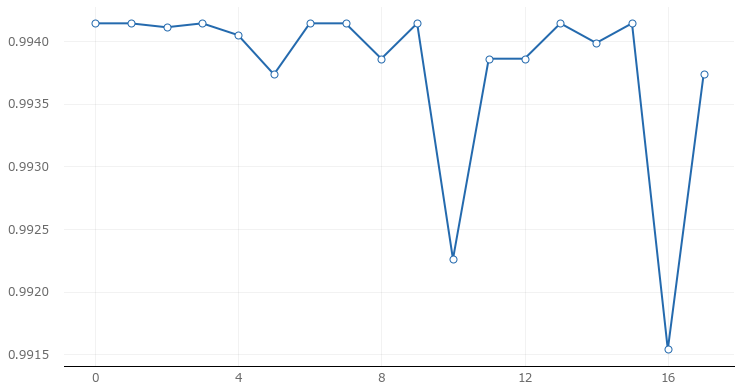

In [65]:
analyze_object.plot_line('val_accuracy')

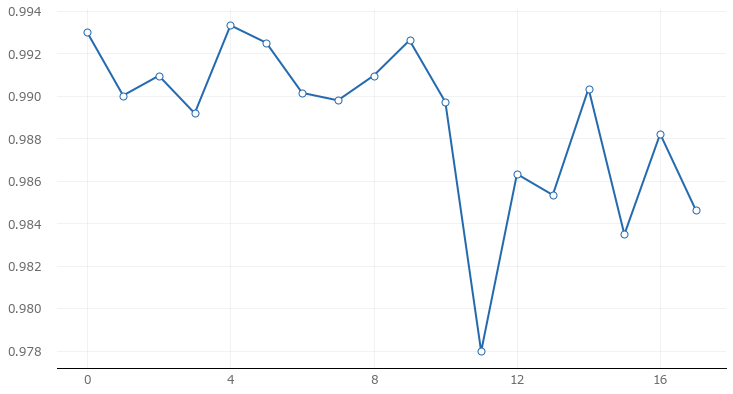

In [66]:
analyze_object.plot_line('accuracy')

#### Talos Grid Search  for LSTM-CNN Model

In [67]:
def toxic_classifier(x_train,y_train,x_val,y_val,params):

    inp=Input(shape=(maxpadlen, ),dtype='int32')

    embedding_layer = Embedding(len(word_index) + 1,
                           embedding_dim_fasttext,
                           weights = [embedding_matrix_fasttext],
                           input_length = maxpadlen,
                           trainable=False,
                           name = 'embeddings')
    embedded_sequences = embedding_layer(inp)

    x = LSTM(params['output_count_lstm'], return_sequences=True,name='lstm_layer')(embedded_sequences)

    x = Conv1D(filters=params['filters'], kernel_size=params['kernel_size'], padding='same', activation='relu', kernel_initializer='he_uniform')(x)

    x = MaxPooling1D(params['pool_size'])(x)

    x = GlobalMaxPool1D()(x)

    x = BatchNormalization()(x)

    x = Dense(params['output_1_count_dense'], activation=params['activation'], kernel_initializer='he_uniform')(x)

    x = Dropout(params['dropout'])(x)

    x = Dense(params['output_2_count_dense'], activation=params['activation'], kernel_initializer='he_uniform')(x)

    x = Dropout(params['dropout'])(x)

    preds = Dense(6, activation=params['last_activation'], kernel_initializer='glorot_uniform')(x)

    model = Model(inputs=inp, outputs=preds)

    model.compile(loss=params['loss'], optimizer=params['optimizer'], metrics=['accuracy'])

    model_info=model.fit(x_train,y_train, epochs=params['epochs'], batch_size=params['batch_size'],  validation_data=(x_val, y_val))

    return model_info, model

In [68]:
p={
    'output_count_lstm': [50,60],
    'output_1_count_dense': [40,50],
    'output_2_count_dense': [30,40],
    'filters' : [64],
    'kernel_size' : [3],
    'batch_size': [32],
    'pool_size': [3],
    'epochs':[2],
    'optimizer':['adam'],
    'activation':['relu'],
    'last_activation': ['sigmoid'],
    'dropout':[0.1,0.2],
    'loss': ['binary_crossentropy']   
}

In [69]:
scan_results = talos.Scan(x=x_train,
               y=y_train,
               x_val=x_val,
               y_val=y_val,
               model=toxic_classifier,
               params=p,
               experiment_name='tcc',
               print_params=True)

  0%|                                                                                           | 0/16 [00:00<?, ?it/s]

{'output_count_lstm': 50, 'output_1_count_dense': 40, 'output_2_count_dense': 30, 'filters': 64, 'kernel_size': 3, 'batch_size': 32, 'pool_size': 3, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.1, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 508s 127ms/step - loss: 0.0654 - accuracy: 0.9559 - val_loss: 0.0486 - val_accuracy: 0.9941
Epoch 2/2
3990/3990 [==============================] - 486s 122ms/step - loss: 0.0492 - accuracy: 0.9853 - val_loss: 0.0485 - val_accuracy: 0.9926


  6%|█████                                                                           | 1/16 [16:35<4:08:50, 995.34s/it]

{'output_count_lstm': 50, 'output_1_count_dense': 40, 'output_2_count_dense': 30, 'filters': 64, 'kernel_size': 3, 'batch_size': 32, 'pool_size': 3, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.2, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 513s 128ms/step - loss: 0.0699 - accuracy: 0.9155 - val_loss: 0.0518 - val_accuracy: 0.9941
Epoch 2/2
3990/3990 [==============================] - 472s 118ms/step - loss: 0.0513 - accuracy: 0.9900 - val_loss: 0.0501 - val_accuracy: 0.9941


 12%|██████████                                                                      | 2/16 [33:03<3:51:12, 990.86s/it]

{'output_count_lstm': 50, 'output_1_count_dense': 40, 'output_2_count_dense': 40, 'filters': 64, 'kernel_size': 3, 'batch_size': 32, 'pool_size': 3, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.1, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 538s 134ms/step - loss: 0.0644 - accuracy: 0.9195 - val_loss: 0.0470 - val_accuracy: 0.9941
Epoch 2/2
3990/3990 [==============================] - 482s 121ms/step - loss: 0.0485 - accuracy: 0.9841 - val_loss: 0.0446 - val_accuracy: 0.9936


 19%|██████████████▊                                                                | 3/16 [50:03<3:37:37, 1004.42s/it]

{'output_count_lstm': 50, 'output_1_count_dense': 40, 'output_2_count_dense': 40, 'filters': 64, 'kernel_size': 3, 'batch_size': 32, 'pool_size': 3, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.2, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 504s 126ms/step - loss: 0.0685 - accuracy: 0.9172 - val_loss: 0.0569 - val_accuracy: 0.9941
Epoch 2/2
3990/3990 [==============================] - 507s 127ms/step - loss: 0.0507 - accuracy: 0.9860 - val_loss: 0.0504 - val_accuracy: 0.9941


 25%|███████████████████▎                                                         | 4/16 [1:06:56<3:21:31, 1007.63s/it]

{'output_count_lstm': 50, 'output_1_count_dense': 50, 'output_2_count_dense': 30, 'filters': 64, 'kernel_size': 3, 'batch_size': 32, 'pool_size': 3, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.1, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 515s 128ms/step - loss: 0.0642 - accuracy: 0.8990 - val_loss: 0.0472 - val_accuracy: 0.9940
Epoch 2/2
3990/3990 [==============================] - 494s 124ms/step - loss: 0.0488 - accuracy: 0.9821 - val_loss: 0.0453 - val_accuracy: 0.9940


 31%|████████████████████████                                                     | 5/16 [1:23:46<3:04:53, 1008.50s/it]

{'output_count_lstm': 50, 'output_1_count_dense': 50, 'output_2_count_dense': 30, 'filters': 64, 'kernel_size': 3, 'batch_size': 32, 'pool_size': 3, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.2, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 511s 128ms/step - loss: 0.0669 - accuracy: 0.8926 - val_loss: 0.0568 - val_accuracy: 0.9893
Epoch 2/2
3990/3990 [==============================] - 511s 128ms/step - loss: 0.0512 - accuracy: 0.9867 - val_loss: 0.0475 - val_accuracy: 0.9938


 38%|████████████████████████████▉                                                | 6/16 [1:40:49<2:48:56, 1013.64s/it]

{'output_count_lstm': 50, 'output_1_count_dense': 50, 'output_2_count_dense': 40, 'filters': 64, 'kernel_size': 3, 'batch_size': 32, 'pool_size': 3, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.1, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 720s 180ms/step - loss: 0.0627 - accuracy: 0.9276 - val_loss: 0.0494 - val_accuracy: 0.9941
Epoch 2/2
3990/3990 [==============================] - 672s 168ms/step - loss: 0.0488 - accuracy: 0.9867 - val_loss: 0.0481 - val_accuracy: 0.9941


 44%|█████████████████████████████████▋                                           | 7/16 [2:04:03<2:50:41, 1137.93s/it]

{'output_count_lstm': 50, 'output_1_count_dense': 50, 'output_2_count_dense': 40, 'filters': 64, 'kernel_size': 3, 'batch_size': 32, 'pool_size': 3, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.2, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 717s 179ms/step - loss: 0.0653 - accuracy: 0.9022 - val_loss: 0.0540 - val_accuracy: 0.9941
Epoch 2/2
3990/3990 [==============================] - 684s 171ms/step - loss: 0.0505 - accuracy: 0.9823 - val_loss: 0.0471 - val_accuracy: 0.9940


 50%|██████████████████████████████████████▌                                      | 8/16 [2:27:25<2:42:55, 1221.98s/it]

{'output_count_lstm': 60, 'output_1_count_dense': 40, 'output_2_count_dense': 30, 'filters': 64, 'kernel_size': 3, 'batch_size': 32, 'pool_size': 3, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.1, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 760s 190ms/step - loss: 0.0622 - accuracy: 0.9032 - val_loss: 0.0483 - val_accuracy: 0.9790
Epoch 2/2
3990/3990 [==============================] - 747s 187ms/step - loss: 0.0490 - accuracy: 0.9827 - val_loss: 0.0446 - val_accuracy: 0.9938


 56%|███████████████████████████████████████████▎                                 | 9/16 [2:52:34<2:33:01, 1311.66s/it]

{'output_count_lstm': 60, 'output_1_count_dense': 40, 'output_2_count_dense': 30, 'filters': 64, 'kernel_size': 3, 'batch_size': 32, 'pool_size': 3, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.2, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 784s 196ms/step - loss: 0.0716 - accuracy: 0.8642 - val_loss: 0.0492 - val_accuracy: 0.9941
Epoch 2/2
3990/3990 [==============================] - 796s 200ms/step - loss: 0.0515 - accuracy: 0.9867 - val_loss: 0.0469 - val_accuracy: 0.9941


 62%|███████████████████████████████████████████████▌                            | 10/16 [3:18:55<2:19:29, 1394.95s/it]

{'output_count_lstm': 60, 'output_1_count_dense': 40, 'output_2_count_dense': 40, 'filters': 64, 'kernel_size': 3, 'batch_size': 32, 'pool_size': 3, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.1, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 795s 199ms/step - loss: 0.0622 - accuracy: 0.9318 - val_loss: 0.0481 - val_accuracy: 0.9940
Epoch 2/2
3990/3990 [==============================] - 723s 181ms/step - loss: 0.0485 - accuracy: 0.9742 - val_loss: 0.0437 - val_accuracy: 0.9877


 69%|████████████████████████████████████████████████████▎                       | 11/16 [3:44:15<1:59:25, 1433.15s/it]

{'output_count_lstm': 60, 'output_1_count_dense': 40, 'output_2_count_dense': 40, 'filters': 64, 'kernel_size': 3, 'batch_size': 32, 'pool_size': 3, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.2, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 674s 168ms/step - loss: 0.0662 - accuracy: 0.9162 - val_loss: 0.0499 - val_accuracy: 0.9941
Epoch 2/2
3990/3990 [==============================] - 730s 183ms/step - loss: 0.0515 - accuracy: 0.9807 - val_loss: 0.0480 - val_accuracy: 0.9937


 75%|█████████████████████████████████████████████████████████                   | 12/16 [4:07:40<1:34:58, 1424.66s/it]

{'output_count_lstm': 60, 'output_1_count_dense': 50, 'output_2_count_dense': 30, 'filters': 64, 'kernel_size': 3, 'batch_size': 32, 'pool_size': 3, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.1, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 823s 206ms/step - loss: 0.0654 - accuracy: 0.8926 - val_loss: 0.0539 - val_accuracy: 0.9939
Epoch 2/2
3990/3990 [==============================] - 786s 197ms/step - loss: 0.0495 - accuracy: 0.9790 - val_loss: 0.0477 - val_accuracy: 0.9934


 81%|█████████████████████████████████████████████████████████████▊              | 13/16 [4:34:31<1:14:02, 1480.88s/it]

{'output_count_lstm': 60, 'output_1_count_dense': 50, 'output_2_count_dense': 30, 'filters': 64, 'kernel_size': 3, 'batch_size': 32, 'pool_size': 3, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.2, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 821s 205ms/step - loss: 0.0682 - accuracy: 0.8699 - val_loss: 0.0495 - val_accuracy: 0.9940
Epoch 2/2
3990/3990 [==============================] - 834s 209ms/step - loss: 0.0510 - accuracy: 0.9787 - val_loss: 0.0464 - val_accuracy: 0.9934


 88%|████████████████████████████████████████████████████████████████████▎         | 14/16 [5:02:08<51:08, 1534.15s/it]

{'output_count_lstm': 60, 'output_1_count_dense': 50, 'output_2_count_dense': 40, 'filters': 64, 'kernel_size': 3, 'batch_size': 32, 'pool_size': 3, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.1, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 815s 204ms/step - loss: 0.0612 - accuracy: 0.9118 - val_loss: 0.0494 - val_accuracy: 0.9941
Epoch 2/2
3990/3990 [==============================] - 825s 207ms/step - loss: 0.0486 - accuracy: 0.9835 - val_loss: 0.0516 - val_accuracy: 0.9930


 94%|█████████████████████████████████████████████████████████████████████████▏    | 15/16 [5:29:29<26:06, 1566.53s/it]

{'output_count_lstm': 60, 'output_1_count_dense': 50, 'output_2_count_dense': 40, 'filters': 64, 'kernel_size': 3, 'batch_size': 32, 'pool_size': 3, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.2, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 948s 237ms/step - loss: 0.0663 - accuracy: 0.9184 - val_loss: 0.0495 - val_accuracy: 0.9941
Epoch 2/2
3990/3990 [==============================] - 962s 241ms/step - loss: 0.0512 - accuracy: 0.9826 - val_loss: 0.0478 - val_accuracy: 0.9939


100%|██████████████████████████████████████████████████████████████████████████████| 16/16 [6:01:20<00:00, 1355.06s/it]


In [70]:
model_id = scan_results.data['val_accuracy'].astype('float').argmax()
model_id

1

In [71]:
scan_results.data[8:9]

,start,end,duration,round_epochs,loss,accuracy,val_loss,val_accuracy,output_count_lstm,output_1_count_dense,...,filters,kernel_size,batch_size,pool_size,epochs,optimizer,activation,last_activation,dropout,loss
8,11/12/22-200418,11/12/22-202926,1508.185208,2,0.049002,0.982711,0.044594,0.993765,60,40,...,64,3,32,3,2,adam,relu,sigmoid,0.1,binary_crossentropy


In [72]:
analyze_object = talos.Analyze(scan_results)

In [73]:
analyze_object.best_params('val_accuracy', ['accuracy', 'loss', 'val_loss'])

array([[986.9741706848145, 50, 64, 32, '11/12/22-175327', 3, 'sigmoid',
        '11/12/22-180954', 3, 'adam', 40, 0.2, 2, 30, 'relu', 2, 0],
       [1393.1628935337067, 50, 64, 32, '11/12/22-191742', 3, 'sigmoid',
        '11/12/22-194055', 3, 'adam', 50, 0.1, 2, 40, 'relu', 2, 1],
       [1580.7281601428986, 60, 64, 32, '11/12/22-202926', 3, 'sigmoid',
        '11/12/22-205547', 3, 'adam', 40, 0.2, 2, 30, 'relu', 2, 2],
       [1011.701762676239, 50, 64, 32, '11/12/22-182656', 3, 'sigmoid',
        '11/12/22-184347', 3, 'adam', 40, 0.2, 2, 40, 'relu', 2, 3],
       [1401.2228758335114, 50, 64, 32, '11/12/22-194056', 3, 'sigmoid',
        '11/12/22-200417', 3, 'adam', 50, 0.2, 2, 40, 'relu', 2, 4],
       [1009.3850853443146, 50, 64, 32, '11/12/22-184348', 3, 'sigmoid',
        '11/12/22-190038', 3, 'adam', 50, 0.1, 2, 30, 'relu', 2, 5],
       [1910.273768901825, 60, 64, 32, '11/12/22-230622', 3, 'sigmoid',
        '11/12/22-233812', 3, 'adam', 50, 0.2, 2, 40, 'relu', 2, 6],
       [1

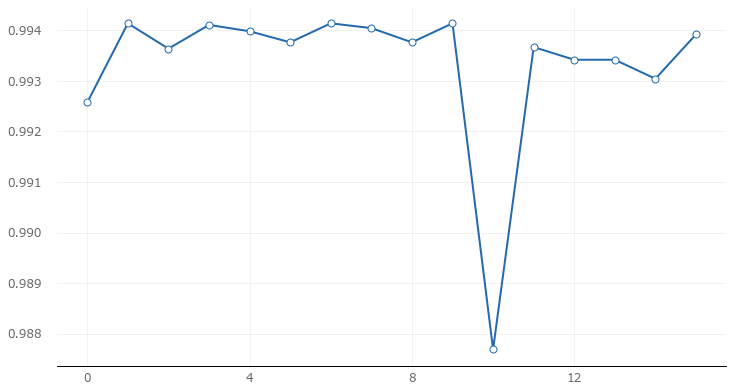

In [74]:
analyze_object.plot_line('val_accuracy')

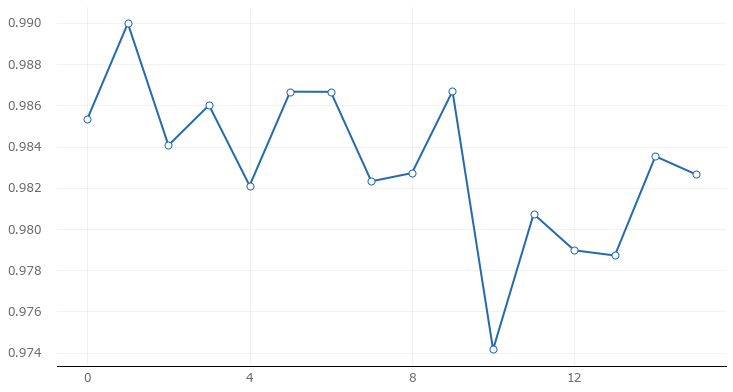

In [75]:
analyze_object.plot_line('accuracy')

#### Training Model with Best Parameters

LSTM

In [76]:
inp=Input(shape=(maxpadlen, ),dtype='int32')

In [77]:
embedding_layer = Embedding(len(word_index) + 1,
                           embedding_dim_fasttext,
                           weights = [embedding_matrix_fasttext],
                           input_length = maxpadlen,
                           trainable=False,
                           name = 'embeddings')
embedded_sequences = embedding_layer(inp)

In [78]:
x = LSTM(40, return_sequences=True,name='lstm_layer')(embedded_sequences)
x = GlobalMaxPool1D()(x)
x = Dropout(0.1)(x)
x = Dense(30, activation="relu", kernel_initializer='he_uniform')(x)
x = Dropout(0.1)(x)
preds = Dense(6, activation="sigmoid", kernel_initializer='glorot_uniform')(x)

In [79]:
model_1 = Model(inputs=inp, outputs=preds)
model_1.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

In [80]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200)]             0         
                                                                 
 embeddings (Embedding)      (None, 200, 300)          50381400  
                                                                 
 lstm_layer (LSTM)           (None, 200, 40)           54560     
                                                                 
 global_max_pooling1d (Globa  (None, 40)               0         
 lMaxPooling1D)                                                  
                                                                 
 dropout (Dropout)           (None, 40)                0         
                                                                 
 dense (Dense)               (None, 30)                1230      
                                                             

In [81]:
model_info_1=model_1.fit(x_train,y_train, epochs=2, batch_size=32,  validation_data=(x_val, y_val))

Epoch 1/2
3990/3990 [==============================] - 590s 147ms/step - loss: 0.0657 - accuracy: 0.9055 - val_loss: 0.0476 - val_accuracy: 0.9941
Epoch 2/2
3990/3990 [==============================] - 591s 148ms/step - loss: 0.0477 - accuracy: 0.9907 - val_loss: 0.0447 - val_accuracy: 0.9942


In [82]:
len(comments_test)

153164

In [83]:
for i in X_te[:5]:
    i = [i]
    i = np.array(i)
    print(model_1.predict(i))
  

[[0.9840216  0.34928212 0.90551925 0.06273744 0.79092085 0.13645089]]
[[1.1435449e-03 8.1790586e-07 9.6111653e-05 1.7773749e-05 1.0770535e-04
  6.4158844e-06]]
[[2.0774603e-03 3.8867611e-06 1.9910932e-04 6.7288478e-05 2.3165345e-04
  2.4963665e-05]]
[[7.8600645e-04 2.8651240e-07 6.6901230e-05 6.4030482e-06 6.6934794e-05
  3.1073189e-06]]
[[4.7729313e-03 1.0014156e-05 4.1759014e-04 1.4892220e-04 5.6219101e-04
  6.1101782e-05]]


LSTM-CNN

In [84]:
inp=Input(shape=(maxpadlen, ),dtype='int32')

In [85]:
embedding_layer = Embedding(len(word_index) + 1,
                           embedding_dim_fasttext,
                           weights = [embedding_matrix_fasttext],
                           input_length = maxpadlen,
                           trainable=False,
                           name = 'embeddings')
embedded_sequences = embedding_layer(inp)

In [86]:
x = LSTM(50, return_sequences=True,name='lstm_layer')(embedded_sequences)
x = Conv1D(filters=64, kernel_size=3, padding='same', activation='relu', kernel_initializer='he_uniform')(x)
x = MaxPooling1D(3)(x)
x = GlobalMaxPool1D()(x)
x = BatchNormalization()(x)
x = Dense(40, activation="relu", kernel_initializer='he_uniform')(x)
x = Dropout(0.2)(x)
x = Dense(30, activation="relu", kernel_initializer='he_uniform')(x)
x = Dropout(0.2)(x)
preds = Dense(6, activation="sigmoid", kernel_initializer='glorot_uniform')(x)

In [87]:
model_2 = Model(inputs=inp, outputs=preds)
model_2.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

In [88]:
model_2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 200)]             0         
                                                                 
 embeddings (Embedding)      (None, 200, 300)          50381400  
                                                                 
 lstm_layer (LSTM)           (None, 200, 50)           70200     
                                                                 
 conv1d (Conv1D)             (None, 200, 64)           9664      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 66, 64)           0         
 )                                                               
                                                                 
 global_max_pooling1d_1 (Glo  (None, 64)               0         
 balMaxPooling1D)                                          

In [89]:
model_info_2=model_2.fit(x_train,y_train, epochs=2, batch_size=32,  validation_data=(x_val, y_val))

Epoch 1/2
3990/3990 [==============================] - 755s 189ms/step - loss: 0.0670 - accuracy: 0.9142 - val_loss: 0.0546 - val_accuracy: 0.9941
Epoch 2/2
3990/3990 [==============================] - 704s 177ms/step - loss: 0.0511 - accuracy: 0.9815 - val_loss: 0.0466 - val_accuracy: 0.9941


In [95]:
test_labels = pd.read_csv("data/test_labels.csv")


In [111]:
test_labels

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,-1,-1,-1,-1,-1,-1
1,0000247867823ef7,-1,-1,-1,-1,-1,-1
2,00013b17ad220c46,-1,-1,-1,-1,-1,-1
3,00017563c3f7919a,-1,-1,-1,-1,-1,-1
4,00017695ad8997eb,-1,-1,-1,-1,-1,-1
...,...,...,...,...,...,...,...
153159,fffcd0960ee309b5,-1,-1,-1,-1,-1,-1
153160,fffd7a9a6eb32c16,-1,-1,-1,-1,-1,-1
153161,fffda9e8d6fafa9e,-1,-1,-1,-1,-1,-1
153162,fffe8f1340a79fc2,-1,-1,-1,-1,-1,-1


In [110]:
test_labels.columns

Index(['id', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult',
       'identity_hate'],
      dtype='object')

In [109]:
test_labels.columns[1:]

Index(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult',
       'identity_hate'],
      dtype='object')

In [108]:
test_labels[test_labels.columns[1:]].values

array([[-1, -1, -1, -1, -1, -1],
       [-1, -1, -1, -1, -1, -1],
       [-1, -1, -1, -1, -1, -1],
       ...,
       [-1, -1, -1, -1, -1, -1],
       [-1, -1, -1, -1, -1, -1],
       [-1, -1, -1, -1, -1, -1]], dtype=int64)

In [112]:
t_y = list(test_labels[test_labels.columns[1:]].values)
len(t_y)
#t_labels = list(test_labels[labels])

153164

In [ ]:
"""c1 = 0
c2 = 0
for i,j in zip(X_te[:100],t_y[0:100]):
  i = [i]
  i = np.array(i)
  x = model_1.predict(i)[0]
  p = [1 if k>0.5 else 0 for k in x]
  if p == list(j):
    c1 += 1
for i,j in zip(X_te[:100],t_y[0:100]):
  i = [i]
  i = np.array(i)
  x = model_2.predict(i)[0]
  p = [1 if k>0.5 else 0 for k in x]
  if p == list(j):
    c2 += 1

print(c1/100,c2/100)"""

In [97]:
m1 = model_1.predict(X_te)


In [98]:
m2 = model_2.predict(X_te)

In [117]:
def accuracy(predicted,actual):
    c = 0
    for i,j in zip(predicted,actual):
        p = [1 if k>0.5 else 0 for k in i]
        if p == list(j):
            c += 1
    return c/63978

In [118]:
a1 = accuracy(m1,t_y)
a2 = accuracy(m2,t_y)
print(a1,a2)

0.8829285066741692 0.8895088936822032


## Plotting Graphs

### LSTM

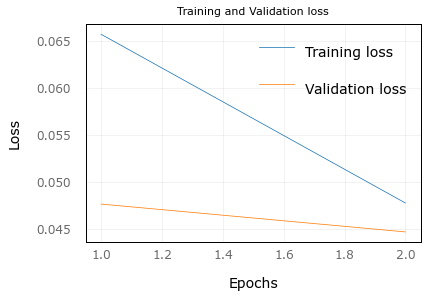

In [119]:
loss = model_info_1.history['loss']
val_loss = model_info_1.history['val_loss']

epochs = range(1, len(loss)+1)

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show();

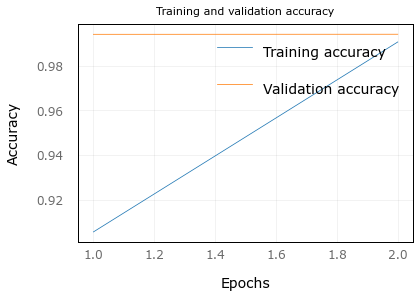

In [120]:
accuracy = model_info_1.history['accuracy']
val_accuracy = model_info_1.history['val_accuracy']

plt.plot(epochs, accuracy, label='Training accuracy')
plt.plot(epochs, val_accuracy, label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show();

### LSTM-CNN

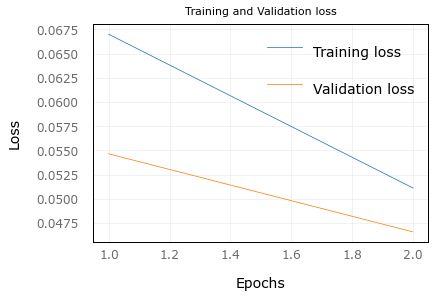

In [121]:
loss = model_info_2.history['loss']
val_loss = model_info_2.history['val_loss']

epochs = range(1, len(loss)+1)

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show();

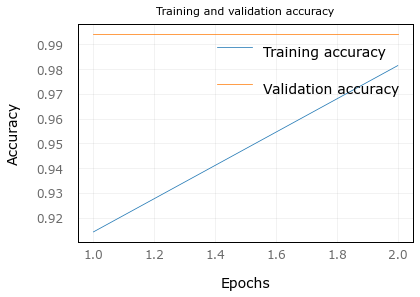

In [122]:
accuracy = model_info_2.history['accuracy']
val_accuracy = model_info_2.history['val_accuracy']

plt.plot(epochs, accuracy, label='Training accuracy')
plt.plot(epochs, val_accuracy, label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show();

# Saving the Model

In [123]:
model_1.save("./LSTM")

INFO:tensorflow:Assets written to: ./LSTM\assets


INFO:tensorflow:Assets written to: ./LSTM\assets


In [124]:
model_2.save("./LSTM-CNN")

INFO:tensorflow:Assets written to: ./LSTM-CNN\assets


INFO:tensorflow:Assets written to: ./LSTM-CNN\assets


# Loading Saved Model

In [11]:
pip uninstall google-api-python-client

Note: you may need to restart the kernel to use updated packages.


In [18]:
import keras
loaded_model_1 = keras.models.load_model("./LSTM")

In [19]:
loaded_model_2 = keras.models.load_model("./LSTM-CNN")

# Testing the Created Model

In [22]:
def toxicity_level(string):
    new_string = [string]
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(new_string)
    new_string = tokenizer.texts_to_sequences(new_string)
    new_string = pad_sequences(new_string, maxlen=maxpadlen, padding='post')
    print(new_string)
    print(new_string.shape)
    
    prediction = loaded_model_1.predict(new_string) #(Change to model_1 or model_2 depending on the preference of model type|| Model 1: LSTM, Model 2:LSTM-CNN)
    toxic_levels = ["TOXIC","SEVERE TOXIC","OBSCENE","THREAT","INSULT","IDENTITY HATE"]
    #print(prediction)
    print("Toxicity levels for '{}':".format(string))
    print(toxic_levels[0],':         {:.0%}'.format(prediction[0][0]))
    print(toxic_levels[1],':  {:.0%}'.format(prediction[0][1]))
    print(toxic_levels[2],':       {:.0%}'.format(prediction[0][2]))
    print(toxic_levels[3],':        {:.0%}'.format(prediction[0][3]))
    print(toxic_levels[4],':        {:.0%}'.format(prediction[0][4]))
    print(toxic_levels[5],': {:.0%}'.format(prediction[0][5]))
    print()
    m = max(prediction[0])
    t = toxic_levels[np.argmax(prediction[0])]
    
    return [t,m]

In [23]:
toxicity_level('go jump off a bridge jerk')

[[1 2 3 4 5 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(1, 200)
Toxicity levels for 'go jump off a bridge jerk':
TOXIC :         2%
SEVERE TOXIC :  0%
OBSCENE :       0%
THREAT :        0%
INSULT :        0%
IDENTITY HATE : 0%



['TOXIC', 0.020663738]

In [24]:
toxicity_level('i will kill you')

[[1 2 3 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(1, 200)
Toxicity levels for 'i will kill you':
TOXIC :         1%
SEVERE TOXIC :  0%
OBSCENE :       0%
THREAT :        0%
INSULT :        0%
IDENTITY HATE : 0%



['TOXIC', 0.010325074]

In [39]:
toxicity_level(" ")

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(1, 200)
Toxicity levels for ' ':
TOXIC :         2%
SEVERE TOXIC :  0%
OBSCENE :       0%
THREAT :        0%
INSULT :        0%
IDENTITY HATE : 0%



['TOXIC', 0.015049219]

In [26]:
toxicity_level('fuck ofF!!')

[[1 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(1, 200)
Toxicity levels for 'fuck ofF!!':
TOXIC :         1%
SEVERE TOXIC :  0%
OBSCENE :       0%
THREAT :        0%
INSULT :        0%
IDENTITY HATE : 0%



['TOXIC', 0.014519095]

In [27]:
toxicity_level('Hello, How are you?')

[[1 2 3 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(1, 200)
Toxicity levels for 'Hello, How are you?':
TOXIC :         1%
SEVERE TOXIC :  0%
OBSCENE :       0%
THREAT :        0%
INSULT :        0%
IDENTITY HATE : 0%



['TOXIC', 0.010325074]

In [31]:
toxicity_level('get the fuck away from me @sshole!!')

[[1 2 3 4 5 6 7 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
(1, 200)
Toxicity levels for 'get the fuck away from me @sshole!!':
TOXIC :         3%
SEVERE TOXIC :  0%
OBSCENE :       0%
THREAT :        0%
INSULT :        1%
IDENTITY HATE : 0%



['TOXIC', 0.03353131]